# Exploring and cleaning the dataset

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib

#!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS

matplotlib.style.use('ggplot')
%matplotlib inline

The dataset consists on two files:
- outcomes.tsv: this file contains the result for different auctions, including the description of the product, its retail price and selling price, the winnner of the auction, the number of placed bids, etc.
- traces.tsv: this file contains the record of all of the bids that were placed for several auctions, including the user who placed each bid, the bidding time, etc.

The dataset can be found in the following link:
http://people.bu.edu/zg/swoopo.html

Dataset authors:

John Byers, Michael Mitzenmacher, Georgios Zervas,
"Information Asymmetries in Pay-Per-Bid Auctions: How Swoopo Makes Bank"

In [2]:
outcomesDf = pd.read_csv('./outcomes.tsv',sep='\t')
tracesDf = pd.read_csv('./traces.tsv',sep='\t')

# outcomes.tsv

The file outcomes.tsv included in the dataset contains the following columns:

- auction_id: unique numerical id for the auction
- product_id: unique product id
- item: text string describing the product
- desc: more information about the product
- retail: the stated retail value of the item, in dollars
- price: the price the auction reached, in dollars
- finalprice: the price charged to the winner in dollars. For certain types of auctions, the value in this column may difer from the value specified in column "price". For example, this may happend in fixed-price auctions or 100%-off auctions (auctions in which the final selling price of the product is zero, and the revenue for Swoopo comes exclusively from the bids that are placed).
- bidincrement: the price increment of a bid, in cents
- bidfee: the cost incurred to make a bid, in cents
- winner: the winner's username
- placedbids: the number of paid bids placed by the winner
- freebids: the number of free bids placed by the winner. Limited free bids are offered by Swoopo in certain deal packages, and users placing free bids do not incur in any bid cost.
- endtime_str: the auction's end time.
- flg_click_only: a binary flag indicating a ``NailBiter'' auction (Swoopo  auctions  which  do  not
permit the use of automated bids by a BidButler, which are automatic bidding agents provided by the Swoopo interface that bid according to user-defined instructions. Users are able to define starting and ending price limits for which automated bids shall be placed, as well as the top number of bids that the BidButler is allowed to place. BidButlers place automated bids when the auction timer drops below 10 seconds).
- flg_beginnerauction: a binary flag indicating a beginner auction (auctions restricted to users who haven't previously won any auction in the site).
- flg_fixedprice: a binary flag indicating a fixed-price auction (an auction in which the selling price is fixed from the beginning). 
- flg_endprice: a binary flag indicating a 100\%-off auction (auctions in which the final selling price of the product is zero, and the revenue for Swoopo comes exclusively from the bids that are placed).

In [3]:
outcomesDf.head(2)

,auction_id,product_id,item,desc,retail,price,finalprice,bidincrement,bidfee,winner,placedbids,freebids,endtime_str,flg_click_only,flg_beginnerauction,flg_fixedprice,flg_endprice
0,86827,10009602,sony-ericsson-s500i-unlocked-mysterious-,Sony Ericsson S500i Unlocked Mysterious Green,499.99,13.35,13.35,15,75,Racer11,26,0,19:52 PDT 09-16-2008,0,0,0,0
1,87964,10009881,psp-slim-lite-sony-piano-black,PSP Slim & Lite Sony Piano Black,169.99,74.70,74.70,15,75,Cemo23,65,0,11:17 PDT 08-28-2008,0,0,0,0


In [4]:
outcomesDf.dtypes

auction_id               int64
product_id               int64
item                    object
desc                    object
retail                 float64
price                  float64
finalprice             float64
bidincrement             int64
bidfee                   int64
winner                  object
placedbids               int64
freebids                 int64
endtime_str             object
flg_click_only           int64
flg_beginnerauction      int64
flg_fixedprice           int64
flg_endprice             int64
dtype: object

There are no empty values in the dataset file:

In [5]:
outcomesDf.isnull().values.any()

False

In [6]:
outcomesDf['endtime_str'] = pd.to_datetime(outcomesDf['endtime_str'])

The number of bids that were placed in the auction can be obtained the price the auction reached and the price increment of each bid:

In [7]:
outcomesDf['bids_placed'] = outcomesDf['price']/(outcomesDf['bidincrement']/100)

The total money that Swoopo obtains for an auction is the number of non-free bids placed by all participants multiplied by the bid fee, plus the final selling price of the item paid by the winner:

In [8]:
outcomesDf['swoopo_sale_price'] = outcomesDf['bids_placed']*(outcomesDf['bidfee']/100) + outcomesDf['finalprice']

Therefore, the profit that Swoopo obtains over the retail price of the item is:

In [9]:
outcomesDf['swoopo_profit'] = outcomesDf['swoopo_sale_price']-outcomesDf['retail']

The dataset file includes 121419 auctions that took place between 2008-08-20 and 2009-12-12

In [10]:
outcomesDf.shape

(121419, 20)

In [11]:
min(outcomesDf['endtime_str'])

Timestamp('2008-08-20 14:04:00')

In [12]:
max(outcomesDf['endtime_str'])

Timestamp('2009-12-12 15:10:00')

In order to identify the different items sold in the auctions, the columns "product_id", "item" and "desc" can be used. An analysis of the unique values contained in these columns is now performed. Each one of them contains a different number of unique values. 

In [13]:
len(outcomesDf['product_id'].unique())

2081

In [14]:
len(outcomesDf['item'].unique())

1803

In [15]:
len(outcomesDf['desc'].unique())

1779

In [16]:
def compareProductIdItemDescColumnValues():
    outcomesDfItemDesc =outcomesDf[['product_id','item','desc','endtime_str']]
    productIdColumnValueCounts = outcomesDf['product_id'].value_counts()
    outcomesDfItemDesc = outcomesDfItemDesc.merge(productIdColumnValueCounts.to_frame(),how='left',left_on='product_id',right_index=True)
    outcomesDfItemDesc = outcomesDfItemDesc.rename(columns={'product_id_x': 'product_id', 'product_id_y': 'product_id_count'})

    itemColumnValueCounts = outcomesDf['item'].value_counts()
    outcomesDfItemDesc = outcomesDfItemDesc.merge(itemColumnValueCounts.to_frame(),how='left',left_on='item',right_index=True)
    outcomesDfItemDesc = outcomesDfItemDesc.rename(columns={'item_x': 'item', 'item_y': 'item_count'})

    descColumnValueCounts = outcomesDf['desc'].value_counts()
    outcomesDfItemDesc = outcomesDfItemDesc.merge(descColumnValueCounts.to_frame(),how='left',left_on='desc',right_index=True)
    outcomesDfItemDesc = outcomesDfItemDesc.rename(columns={'desc_x': 'desc', 'desc_y': 'desc_count'})
    
    return outcomesDfItemDesc

outcomesDfItemDesc = compareProductIdItemDescColumnValues()
outcomesDfItemDesc.head()

,product_id,item,desc,endtime_str,product_id_count,item_count,desc_count
0,10009602,sony-ericsson-s500i-unlocked-mysterious-,Sony Ericsson S500i Unlocked Mysterious Green,2008-09-16 19:52:00,10,77,77
1,10009881,psp-slim-lite-sony-piano-black,PSP Slim & Lite Sony Piano Black,2008-08-28 11:17:00,21,60,60
2,10009881,psp-slim-lite-sony-piano-black,PSP Slim & Lite Sony Piano Black,2008-11-07 22:52:00,21,60,60
3,10006115,sony-ericsson-s500i-unlocked-mysterious-,Sony Ericsson S500i Unlocked Mysterious Green,2008-08-23 22:02:00,33,77,77
4,10006115,sony-ericsson-s500i-unlocked-mysterious-,Sony Ericsson S500i Unlocked Mysterious Green,2008-08-24 14:23:00,33,77,77


As it can be observed, the product_id contains different values for rows of the dataset in which the same item is sold. Therefore, the "product_id" value is not a good option to identify unique products.

In [17]:
productIdVsItemDf = outcomesDfItemDesc[(outcomesDfItemDesc['product_id_count']!=outcomesDfItemDesc['item_count'])].drop_duplicates(subset=['product_id','item','desc'])
productIdVsItemDf.shape

(569, 7)

Here is an example:

In [18]:
productIdVsItemDf[productIdVsItemDf['item'].values == 'sony-ericsson-s500i-unlocked-mysterious-']

,product_id,item,desc,endtime_str,product_id_count,item_count,desc_count
0,10009602,sony-ericsson-s500i-unlocked-mysterious-,Sony Ericsson S500i Unlocked Mysterious Green,2008-09-16 19:52:00,10,77,77
3,10006115,sony-ericsson-s500i-unlocked-mysterious-,Sony Ericsson S500i Unlocked Mysterious Green,2008-08-23 22:02:00,33,77,77
5,10008975,sony-ericsson-s500i-unlocked-mysterious-,Sony Ericsson S500i Unlocked Mysterious Green,2008-08-22 22:44:00,15,77,77
17,10009642,sony-ericsson-s500i-unlocked-mysterious-,Sony Ericsson S500i Unlocked Mysterious Green,2008-09-02 00:06:00,11,77,77
17297,10010727,sony-ericsson-s500i-unlocked-mysterious-,Sony Ericsson S500i Unlocked Mysterious Green,2008-11-11 01:46:00,8,77,77


As it can be seen, some items do not contain a description, and the "item" column is the name of an HTML page:

In [19]:
itemVsDescDf = outcomesDfItemDesc[(outcomesDfItemDesc['item_count']!=outcomesDfItemDesc['desc_count'])].drop_duplicates(subset=['item','desc'])
itemVsDescDf = itemVsDescDf.sort_values(by='desc')
itemVsDescDf

,product_id,item,desc,endtime_str,product_id_count,item_count,desc_count
19906,10010818,121881.html,-,2008-11-26 18:03:00,36,1,36
19294,10010818,121215.html,-,2008-11-22 20:04:00,36,1,36
19540,10010818,121470.html,-,2008-11-18 22:01:00,36,1,36
19837,10010818,121788.html,-,2008-11-24 13:05:00,36,1,36
21170,10010818,123276.html,-,2008-11-28 14:25:00,36,1,36
21421,10010818,123553.html,-,2008-11-30 23:24:00,36,1,36
22803,10010818,125284.html,-,2008-12-07 17:10:00,36,1,36
22804,10010818,125285.html,-,2008-12-05 13:18:00,36,1,36
22805,10010818,125286.html,-,2008-12-03 19:51:00,36,1,36
22806,10010818,125287.html,-,2008-12-02 16:39:00,36,1,36


This is the case for 36 rows in the dataframe.

In [20]:
itemVsDescDf[itemVsDescDf.apply(lambda x : "html" in x['item'], axis=1)]

,product_id,item,desc,endtime_str,product_id_count,item_count,desc_count
19906,10010818,121881.html,-,2008-11-26 18:03:00,36,1,36
19294,10010818,121215.html,-,2008-11-22 20:04:00,36,1,36
19540,10010818,121470.html,-,2008-11-18 22:01:00,36,1,36
19837,10010818,121788.html,-,2008-11-24 13:05:00,36,1,36
21170,10010818,123276.html,-,2008-11-28 14:25:00,36,1,36
21421,10010818,123553.html,-,2008-11-30 23:24:00,36,1,36
22803,10010818,125284.html,-,2008-12-07 17:10:00,36,1,36
22804,10010818,125285.html,-,2008-12-05 13:18:00,36,1,36
22805,10010818,125286.html,-,2008-12-03 19:51:00,36,1,36
22806,10010818,125287.html,-,2008-12-02 16:39:00,36,1,36


Since auctions with missing product descriptions would not be very helpful for the analysis, and this only happens for a small number of rows, it has been decided to discard these rows.

In [21]:
htmlItems = ['109104.html', '109746.html', '109786.html', '109830.html',
       '110013.html', '110869.html', '111506.html', '111584.html',
       '112103.html', '112187.html', '114652.html', '114804.html',
       '114907.html', '116626.html', '117910.html', '118838.html',
       '121129.html', '121215.html', '121470.html', '121471.html',
       '121788.html', '121881.html', '123276.html', '123553.html',
       '125284.html', '125285.html', '125286.html', '125287.html',
       '125288.html', '126865.html', '126866.html', '126867.html','130108.html',
       '137897.html', '137898.html', '140035.html']
outcomesDf = outcomesDf[~outcomesDf['item'].isin(htmlItems)]

In most of the cases in which there are different values in the column "desc" for the same value of the column "item", it is due to small grammar differences in the text contained in the column "desc":

In [22]:
outcomesDfItemDesc = compareProductIdItemDescColumnValues()
itemVsDescDf = outcomesDfItemDesc[(outcomesDfItemDesc['item_count']!=outcomesDfItemDesc['desc_count'])].drop_duplicates(subset=['item','desc'])
itemVsDescDf = itemVsDescDf.sort_values(by='desc')
itemVsDescDf

,product_id,item,desc,endtime_str,product_id_count,item_count,desc_count
30862,10011491,casio-exilim-ex-z200-10-1-mp-digital-cam,Casio Exilim EX-Z200 10.1 MP Digital Camera,2009-01-05 02:42:00,43,48,43
25280,10010929,casio-exilim-ex-z200-10-1-mp-digital-cam,Casio Exilim EX-Z200 10.1 MP Digital Camera - RED,2008-12-10 13:43:00,5,48,5
52065,10011838,frigidaire-atf8000fs-white-front-loading,Frigidaire ATF8000FS White Front-Loading Washer,2009-03-15 17:43:00,6,21,6
60454,10012069,frigidaire-atf8000fs-white-front-loading,Frigidaire ATF8000FS White Front-Loading Washer,2009-04-17 21:05:00,8,21,15
7691,10009192,ghd-professional-mini-styler-mk4-5-8-inc,"GHD Professional Mini Styler MK4 ( 5/8"" Inch)",2008-10-06 13:23:00,26,37,26
17351,10011006,ghd-professional-mini-styler-mk4-5-8-inc,"GHD Professional Mini Styler MK4 (5/8"" Inch)",2008-11-08 11:47:00,11,37,11
77943,10012229,garmin-n-vi-205w-4-3-inch-portable-gps-n,Garmin nüvi 205W 4.3-Inch Portable GPS Navigator,2009-06-29 04:30:00,22,37,22
74852,10012230,garmin-n-vi-205w-4-3-inch-portable-gps-n,Garmin nüvi 205W 4.3-Inch Portable GPS Navigator,2009-06-15 07:13:00,15,37,15
506,10008900,lego-city-7743-police-command-center,LEGO City 7743 - Police Command Center,2008-08-21 23:23:00,3,6,3
7652,10010875,lego-city-7743-police-command-center,LEGO City 7743: Police Command Center,2008-10-03 18:48:00,3,6,3


For example, for the item "vtech-v-smile-tv-learning-system" there are two descriptions that actually refer to the same item, but are written slightly differently:

In [23]:
itemVsDescDf[itemVsDescDf['item'].values == "vtech-v-smile-tv-learning-system"]

,product_id,item,desc,endtime_str,product_id_count,item_count,desc_count
503,10009529,vtech-v-smile-tv-learning-system,VTech V.Smile TV Learning System,2008-08-23 05:53:00,4,22,4
13766,10011031,vtech-v-smile-tv-learning-system,Vtech - V.Smile TV Learning System,2008-11-03 04:59:00,18,22,18


The following code lines are used to clean these small differences:

In [24]:
outcomesDf.loc[outcomesDf['item'].values=="vtech-v-smile-tv-learning-system", 'desc'] = "Vtech - V.Smile TV Learning System"
outcomesDf.loc[outcomesDf['item'].values=="lego-city-7743-police-command-center", 'desc'] = "LEGO City 7743 - Police Command Center"
outcomesDf.loc[outcomesDf['item'].values=="samsung-t220hd-22-1080p-lcd-hdtv-monitor", 'desc'] = "Samsung T220HD 22\" 1080p LCD HDTV Monitor"
outcomesDf.loc[outcomesDf['item'].values=="ghd-professional-mini-styler-mk4-5-8-inc", 'desc'] = "GHD Professional Mini Styler MK4 (5/8\" Inch)"
outcomesDf.loc[outcomesDf['item'].values=="frigidaire-atf8000fs-white-front-loading", 'desc'] = "Frigidaire ATF8000FS White Front-Loading Washer"
outcomesDf.loc[outcomesDf['item'].values=="lg-26-5-cu-ft-side-by-side-refrigerator-", 'desc'] = "LG 26.5 cu.ft. Side-By-Side Refrigerator (White)"
outcomesDf.loc[outcomesDf['item'].values=="samsung-bd-p3600-1080p-blu-ray-disc-play", 'desc'] = "Samsung BD-P3600 1080p Blu-Ray Disc Player"
outcomesDf.loc[outcomesDf['item'].values=="garmin-n-vi-205w-4-3-inch-portable-gps-n", 'desc'] = "Garmin nüvi 205W 4.3-Inch Portable GPS Navigator"
outcomesDf.loc[outcomesDf['item'].values=="casio-exilim-ex-z200-10-1-mp-digital-cam", 'desc'] = "Casio Exilim EX-Z200 10.1 MP Digital Camera"

After cleaning the previous product descriptions, the only items left with the same value for the "item" column but with a different value for the "desc" column are two games available in different gaming devices. Since they are conceptually different products, it has been decided to leave the values for the column "desc" as they are.

In [25]:
outcomesDfItemDesc = compareProductIdItemDescColumnValues()
itemVsDescDf = outcomesDfItemDesc[(outcomesDfItemDesc['item_count']!=outcomesDfItemDesc['desc_count'])].drop_duplicates(subset=['item','desc'])
itemVsDescDf = itemVsDescDf.sort_values(by='desc')
itemVsDescDf

,product_id,item,desc,endtime_str,product_id_count,item_count,desc_count
106950,10013994,mario-sonic-at-the-olympic-winter-games-,Mario & Sonic at the Olympic Winter Games (DS),2009-10-25 03:33:00,55,110,55
106964,10013993,mario-sonic-at-the-olympic-winter-games-,Mario & Sonic at the Olympic Winter Games (Wii),2009-10-25 14:03:00,55,110,55
115882,10014797,star-wars-the-clone-wars-republic-heroes,Star Wars: The Clone Wars - Republic Heroes (PC),2009-11-15 18:38:00,24,52,24
106978,10013992,star-wars-the-clone-wars-republic-heroes,Star Wars: The Clone Wars - Republic Heroes (Wii),2009-10-24 19:36:00,28,52,28


As it has been mentioned in the dataset file description, there are special types of auctions:
- Click-only auctions: Swoopo auctions which do not permit the use of automated bids by a BidButler.
- Beginner auctions: auctions restricted to users who have not yet won any auctions.
- Fixed-price auctions: auctions in which the selling price is fixed from the beginning.
- End-price auctions: auctions in which the final selling price of the product is zero.

In [26]:
outcomesDf[['auction_id','bidincrement','bidfee','flg_click_only','flg_beginnerauction','flg_fixedprice','flg_endprice']].head()

,auction_id,bidincrement,bidfee,flg_click_only,flg_beginnerauction,flg_fixedprice,flg_endprice
0,86827,15,75,0,0,0,0
1,87964,15,75,0,0,0,0
2,87965,15,75,0,1,0,0
3,88638,15,75,0,0,0,0
4,88639,15,75,0,0,0,0


In [27]:
countOfTypesOfAuctions = outcomesDf.groupby(['flg_click_only','flg_beginnerauction','flg_fixedprice','flg_endprice'])['auction_id'].count()
countOfTypesOfAuctions

flg_click_only  flg_beginnerauction  flg_fixedprice  flg_endprice
0               0                    0               0               70020
                                                     1                3542
                                     1               0                1968
                1                    0               0               12891
                                                     1                 168
                                     1               0                  40
1               0                    0               0               25335
                                                     1                 814
                                     1               0                 155
                1                    0               0                6413
                                                     1                  32
                                     1               0                   5
Name: auction_id, dtype: int64

In [28]:
isClickOnlyAuction = outcomesDf['flg_click_only'].values == 1
isBeginnerAuction = outcomesDf['flg_beginnerauction'].values == 1
isFixedPriceAuction = outcomesDf['flg_fixedprice'].values == 1
isEndPriceAuction = outcomesDf['flg_endprice'].values == 1

totalNumberOfAuctions = outcomesDf.shape[0]
totalNumberOfClickOnlyAuctions = outcomesDf[isClickOnlyAuction].shape[0]
totalNumberOfBeginnerAuctions = outcomesDf[isBeginnerAuction].shape[0]
totalNumberOfFixedPriceAuctions = outcomesDf[isFixedPriceAuction].shape[0]
totalNumberOfEndPriceAuctions = outcomesDf[isEndPriceAuction].shape[0]
totalNumberOfNormalAuctions = totalNumberOfAuctions - (totalNumberOfClickOnlyAuctions+totalNumberOfBeginnerAuctions+totalNumberOfFixedPriceAuctions+totalNumberOfEndPriceAuctions)

print('Total number of auctions = %d'%totalNumberOfAuctions)
print('Total number of click-only auctions = %d'%totalNumberOfClickOnlyAuctions)
print('Total number of beginner auctions = %d'%totalNumberOfBeginnerAuctions)
print('Total number of fixed-price auctions = %d'%totalNumberOfFixedPriceAuctions)
print('Total number of end-price auctions = %d'%totalNumberOfEndPriceAuctions)
print('Total number of \'normal\' auctions = %d'%totalNumberOfNormalAuctions)

Total number of auctions = 121383
Total number of click-only auctions = 32754
Total number of beginner auctions = 19549
Total number of fixed-price auctions = 2168
Total number of end-price auctions = 4556
Total number of 'normal' auctions = 62356


As it has been mentioned before, the column 'swoopo_profit' indicates the profit that Swoopo obtains over the retail price of the item. Sometimes, Swoopo obtaines a negative profit (i.e., Swoopo sells an item below its retail price).

This is the case for 46.36% of the auctions.

In [29]:
totalNumberOfNegativeProfitAuctions = outcomesDf[outcomesDf['swoopo_profit'] < 0].shape[0]
(totalNumberOfNegativeProfitAuctions/totalNumberOfAuctions)*100

46.3590453358378

Nevertheless, the average profit obtained by Swoopo over the retail price of the items is positive:

In [30]:
averageProfitPerItem = outcomesDf['swoopo_profit'].mean()
averageProfitPerItem

216.9763648946216

The average number of auctions per day is approximately 253:

In [31]:
f = lambda x: str(x.day) + '-' + str(x.month) + '-' + str(x.year)
auctionsPerDay = outcomesDf.groupby(outcomesDf['endtime_str'].apply(f))['auction_id'].count()
averageNumberOfDailyAuctions = auctionsPerDay.mean()
averageNumberOfDailyAuctions

252.88125

That means that, in average, Swoopo obtains a daily profit over the retail price of the sold items of:

In [32]:
averageProfitPerItem*averageNumberOfDailyAuctions

54869.25437500803

The most profitable auctions are, in descending order: fixed-price auctions, 'normal' auctions, end-price auctions, click-only auctions and beginner auctions:

In [33]:
averageProfitOfClickOnlyAuctions = outcomesDf[isClickOnlyAuction]['swoopo_profit'].mean()
averageProfitOfBeginnerAuctions = outcomesDf[isBeginnerAuction]['swoopo_profit'].mean()
averageProfitOfFixedPriceAuctions = outcomesDf[isFixedPriceAuction]['swoopo_profit'].mean()
averageProfitOfEndPriceAuctions = outcomesDf[isEndPriceAuction]['swoopo_profit'].mean()

isNotClickOnlyAuction = outcomesDf['flg_click_only'].values == 0
isNotBeginnerAuction = outcomesDf['flg_beginnerauction'].values == 0
isNotFixedPriceAuction = outcomesDf['flg_fixedprice'].values == 0
isNotEndPriceAuction = outcomesDf['flg_endprice'].values == 0

averageProfitOfNormalAuctions = outcomesDf[isNotClickOnlyAuction & isNotBeginnerAuction & isNotFixedPriceAuction & isNotEndPriceAuction]['swoopo_profit'].mean()

print("Average profit of click-only auctions = %0.2f"%averageProfitOfClickOnlyAuctions + "$")
print("Average profit of beginner auctions = %0.2f"%averageProfitOfBeginnerAuctions + "$")
print("Average profit of fixed-price auctions = %0.2f"%averageProfitOfFixedPriceAuctions + "$")
print("Average profit of end-price auctions = %0.2f"%averageProfitOfEndPriceAuctions + "$")
print("Average profit of \'normal\' auctions = %0.2f"%averageProfitOfNormalAuctions + "$")

Average profit of click-only auctions = 59.96$
Average profit of beginner auctions = 26.65$
Average profit of fixed-price auctions = 679.07$
Average profit of end-price auctions = 243.76$
Average profit of 'normal' auctions = 311.51$


As it can be seen in the image below, the majority of the items that are sold are electronics. There are also some of products that are auctioned that contain the words "voucher" or "bids" in their product description. That is because certain items come along (or directly are in some cases) bids or cash that can be later used by the winnner in other Swoopo auctions.

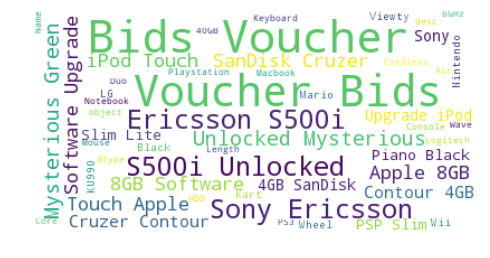

['50 FreeBids Voucher' '300 FreeBids Voucher' '$15 Florist Voucher'
 '$30 Florist Voucher' '50 Bids Voucher' '300 Bids Voucher'
 '20 Bids Voucher' 'Nintendo DSi Console (Black) + 50 Bids Voucher'
 'Nintendo DSi Console (Blue) + 50 Bids Voucher' '75 Bids Voucher']


In [34]:
stopwords = set(STOPWORDS)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(outcomesDf['desc']))

print(wordcloud)
fig = plt.figure(1)
plt.figure(figsize=(8,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

print(outcomesDf['desc'][outcomesDf['desc'].str.contains("Voucher")].unique())

The top 10 winners and the number of auctions that each one won during the period of the dataset are:

In [35]:
winners = outcomesDf.groupby(outcomesDf['winner'])['winner'].count()
winners.sort_values(ascending=False).head(10)

winner
HH0812         131
Oglalasioux    117
Toertchen      116
Koboldwicht    111
Schlumpf01     111
Kavvamartin    110
Thomsen321     109
Brusher        108
Aluf412        108
Trixi101       106
Name: winner, dtype: int64

As it has previosly been mentioned, the dataset contains auctions that ended within 2008-08-20 and 2009-12-12

In [36]:
print(min(outcomesDf['endtime_str']))
print(max(outcomesDf['endtime_str']))

2008-08-20 14:04:00
2009-12-12 15:10:00


In the next figure, the number of bids placed per month is represented. The reason why the number of bids placed in August 2008 and December 2009 is low is because the dataset does not contain data for all days of these months.
In general, it can be observed that November, December and January seem to be the months in which more bids are placed.

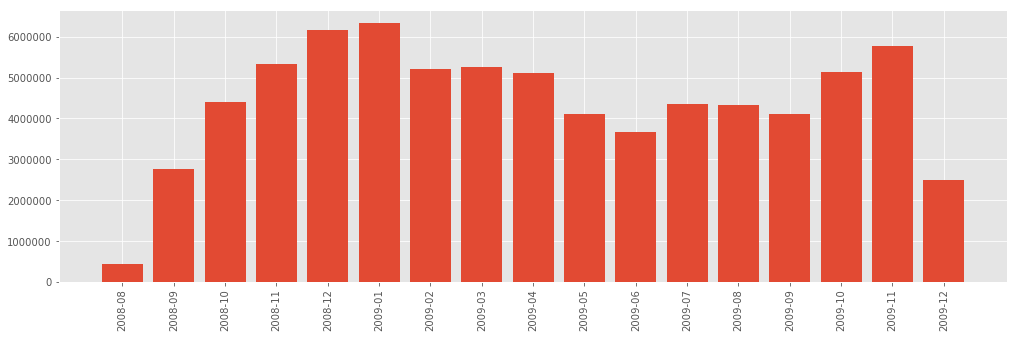

In [37]:
f = lambda x: str(x.year) + '-' + '{0:02d}'.format(x.month)

grupo = outcomesDf.groupby(outcomesDf['endtime_str'].apply(f))['bids_placed'].sum()

X=grupo.values
Y=grupo.index

plt.figure(figsize=(17,5))
plt.bar(range(len(X)), X)
plt.xticks(np.arange(len(X)), Y,rotation='vertical')
plt.show()

Considering the months for which we have the full data both in 2008 and 2009 (September, October and November), it can be seen that, in average, the number of bids placed has increased approximately a 25% in 2009 compared to 2008. These indicates that Swoopo gained popularity over the course of that year.

In [38]:
september2008Index = 1
october2008Index = 2
november2008Index = 3

september20092008NumberOfBidsDiff = (X[september2008Index+12] - X[september2008Index])/X[september2008Index]
october20092008NumberOfBidsDiff = (X[october2008Index+12] - X[october2008Index])/X[october2008Index]
november20092008NumberOfBidsDiff = (X[november2008Index+12] - X[november2008Index])/X[november2008Index]
meanYearlyIncreaseNumberOfBids = np.mean([september20092008NumberOfBidsDiff,october20092008NumberOfBidsDiff,november20092008NumberOfBidsDiff])
print(meanYearlyIncreaseNumberOfBids*100)

24.7388170363


Nevertheless, if the same calculation is performed for the profit obtained by Swoopo over the retail price of the items instead of the number of bids placed, it can be seen that, in average, the profit obtained has decreased approximately a 13% in 2009 compared to 2008.

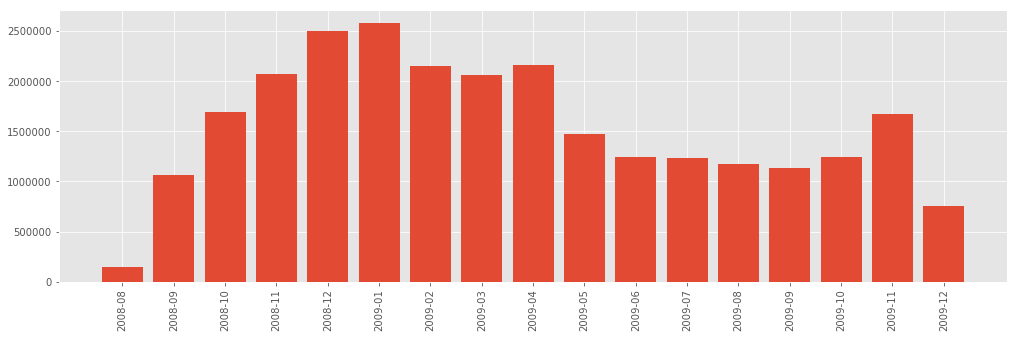

In [39]:
f = lambda x: str(x.year) + '-' + '{0:02d}'.format(x.month)

grupo = outcomesDf.groupby(outcomesDf['endtime_str'].apply(f))['swoopo_profit'].sum()

X=grupo.values
Y=grupo.index

plt.figure(figsize=(17,5))
plt.bar(range(len(X)), X)
plt.xticks(np.arange(len(X)), Y,rotation='vertical')
plt.show()

september2008Index = 1
october2008Index = 2
november2008Index = 3

september20092008SwoopoProfitDiff = (X[september2008Index+12] - X[september2008Index])/X[september2008Index]
october20092008SwoopoProfitDiff = (X[october2008Index+12] - X[october2008Index])/X[october2008Index]
november20092008SwoopoProfitDiff = (X[november2008Index+12] - X[november2008Index])/X[november2008Index]
meanYearlyIncreaseSwoopoProfit = np.mean([september20092008SwoopoProfitDiff,october20092008SwoopoProfitDiff,november20092008SwoopoProfitDiff])


In [40]:
print(meanYearlyIncreaseSwoopoProfit*100)

-13.209071278


The following figure represents the sum of the retail price of the items auctioned monthly as well as the monthly revenue obtained by Swoopo (calculated as the profit obtained over the retail price of the items plus their retail price).

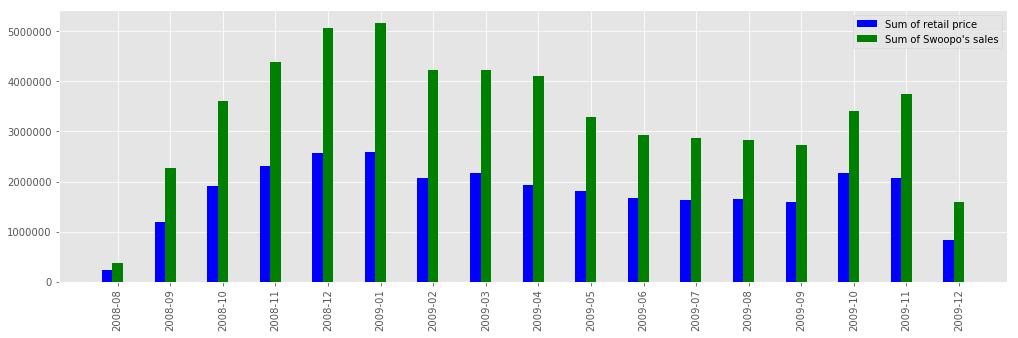

In [41]:
f = lambda x: str(x.year) + '-' + '{0:02d}'.format(x.month)

sumRetailGroup = outcomesDf.groupby(outcomesDf['endtime_str'].apply(f))['retail'].sum()
swoopoProfitGroup = outcomesDf.groupby(outcomesDf['endtime_str'].apply(f))['swoopo_profit'].sum()

X=sumRetailGroup.index
Y=sumRetailGroup.values
Y2 = swoopoProfitGroup.values
bar_width = 0.20

plt.figure(figsize=(17,5))
p1=plt.bar(np.arange(len(Y)),Y, bar_width,color='b')
p2=plt.bar(np.arange(len(Y2))+bar_width,Y2+Y,bar_width, color='g')
plt.xticks(np.arange(len(X)) + bar_width, X,rotation='vertical')
plt.legend((p1,p2),('Sum of retail price', 'Sum of Swoopo\'s sales'))
plt.show()

The protit ratio (calculated as the revenue divided by the retail price) is greater than 1.00 every month. The green line in the following figure represents the average profit obtained:

In [42]:
profitRatio = (Y2+Y)/Y

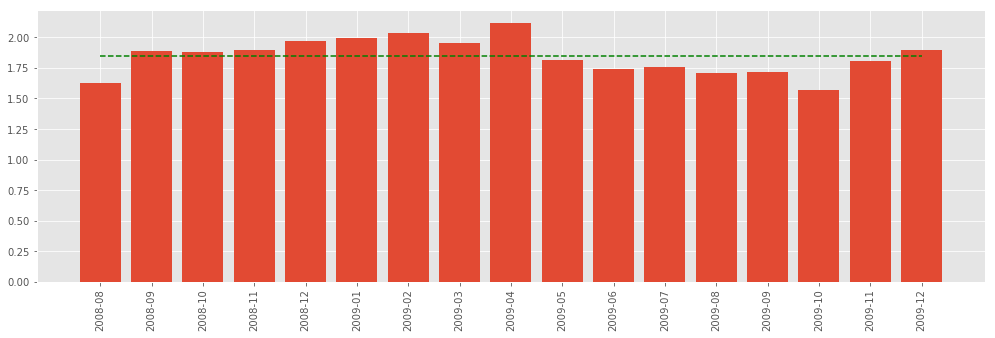

In [43]:
plt.figure(figsize=(17,5))
plt.bar(range(len(profitRatio)), profitRatio)
plt.xticks(np.arange(len(profitRatio)), X,rotation='vertical')
mean_line = plt.plot(np.arange(len(X)),[np.mean(profitRatio)]*len(X), label='Mean', linestyle='--',color='g')
plt.show()
plt.show()

On average, it is 85% times higher:

In [44]:
np.mean(profitRatio)

1.8451302539008025

The time in which the profit is lower corresponds to the period of time between June 2009 and October 2009 (as it can also be seen in the figure above):

In [45]:
profitRatio,X= zip(*sorted(zip(profitRatio,X)))
for i in range(0,10):
    print (str(X[i])+ " : "+str(profitRatio[i]))

2009-10 : 1.57018109411
2008-08 : 1.62336556988
2009-08 : 1.70493396736
2009-09 : 1.71365560047
2009-06 : 1.74433191932
2009-07 : 1.75442610502
2009-11 : 1.80438536565
2009-05 : 1.81462330089
2008-10 : 1.88230182601
2008-09 : 1.8876394394


The following figure also represents the sum of the retail price of the items as well as the revenue obtained by Swoopo, but with weekly granularity instead of monthly granularity:

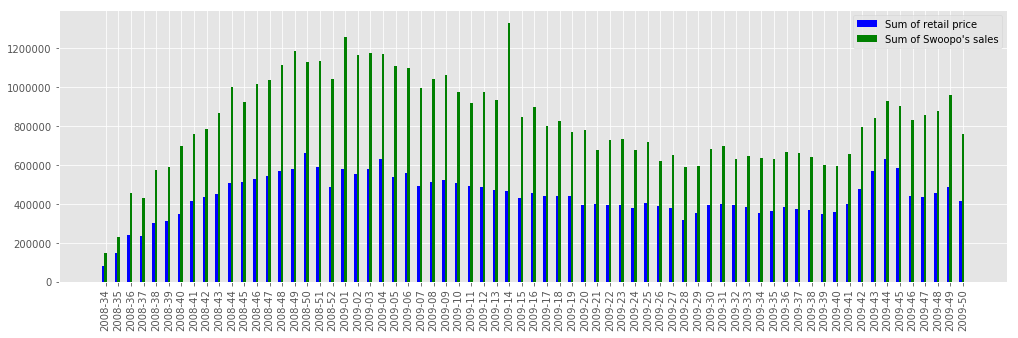

In [46]:
def timeStampToYearWeekFormat(timestamp):
    
    #for index_val, series_val in timeStampSeries.iteritems():
    yearWeekFormatString = str(timestamp.year) + '-' + '{0:02d}'.format(timestamp.weekofyear)
    if yearWeekFormatString == '2008-01':
        #Convert 2008-01 to 2009-01, because some days of the last week of 
        #a year are considered to be in the first week of the next year, 
        #and the data timestamps range from '2008-08-20 14:04:00' to '2009-12-12 15:10:00'
        #The ISO 8601 definition for week 01 is the week with the year's first Thursday in it.
        yearWeekFormatString = '2009-01'
    return yearWeekFormatString
    
sumRetailGroup = outcomesDf.groupby(outcomesDf['endtime_str'].apply(timeStampToYearWeekFormat))['retail'].sum()
swoopoProfitGroup = outcomesDf.groupby(outcomesDf['endtime_str'].apply(timeStampToYearWeekFormat))['swoopo_profit'].sum()

X=sumRetailGroup.index
Y=sumRetailGroup.values
Y2 = swoopoProfitGroup.values
bar_width = 0.20

plt.figure(figsize=(17,5))
p1=plt.bar(np.arange(len(Y)),Y, bar_width,color='b')
p2=plt.bar(np.arange(len(Y2))+bar_width,Y2+Y,bar_width, color='g')
plt.xticks(np.arange(len(X)) + bar_width, X,rotation='vertical')
plt.legend((p1,p2),('Sum of retail price', 'Sum of Swoopo\'s sales'))
plt.show()

The profit ratio has also been calculated weekly, and it can be used to understand the periods that are best for Swoopo's business in terms of profit.

During the last two weeks of a year (2008/51 - 2008/52) plus the three first weeks of the next year (2009/01 - 2008/03) the profit obtained is higher than average, with its peak in the first week of the new year. Week 2009/14 (corresponding to the period from March 30, 2009 to April 5, 2009) is the week in which the highest profit is obtained with a very noticiable difference. The period between weeks 2009/29 - 2009/45 (July 13, 2009 - November 8, 2009) the profit obtained is lower than average.

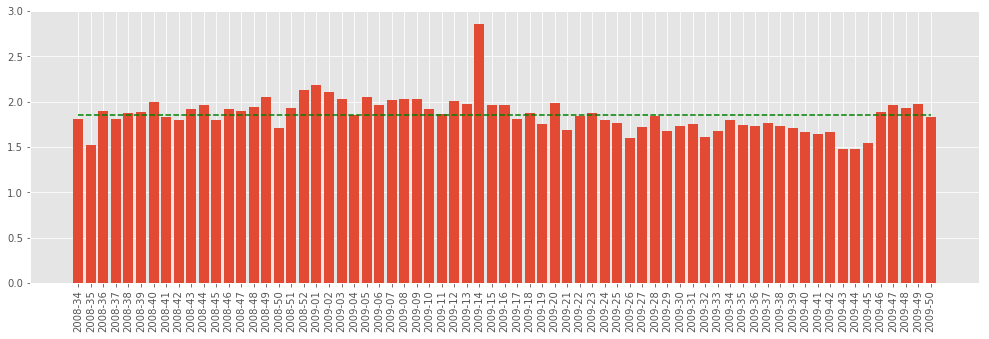

In [47]:
profitRatio = (Y2+Y)/Y
plt.figure(figsize=(17,5))
plt.bar(range(len(profitRatio)), profitRatio)
plt.xticks(np.arange(len(profitRatio)), X,rotation='vertical')
mean_line = plt.plot(np.arange(len(X)),[np.mean(profitRatio)]*len(X), label='Mean', linestyle='--',color='g')
plt.show()

Finally, the daily profit ratio has been calculated to observe how holidays influence Swoopo's business in terms of profit. The z-score of the profit ratio has been calculated to compare the number of standard deviations that the profit ratio is away from its mean value each day.

In [76]:
f = lambda x: str(x)[:10]

sumRetailGroup = outcomesDf.groupby(outcomesDf['endtime_str'].apply(f))['retail'].sum()
swoopoProfitGroup = outcomesDf.groupby(outcomesDf['endtime_str'].apply(f))['swoopo_profit'].sum()

X=sumRetailGroup.index
Y=sumRetailGroup.values
Y2 = swoopoProfitGroup.values

profitRatio = (Y2+Y)/Y
profitRatioZScore = (profitRatio - np.mean(profitRatio))/(np.std(profitRatio))
orderedX = X

profitRatioZScore,orderedX= zip(*sorted(zip(profitRatioZScore,orderedX),reverse=True))

Firstly, the highest 30 z-score values for the profit ratio within the dates contained in the dataset are shown. Several days of the week before 2009's New Year's Eve have high z-score values.  Also, the days between March 28, 2009 and April 6, 2009 have very high z-score values.

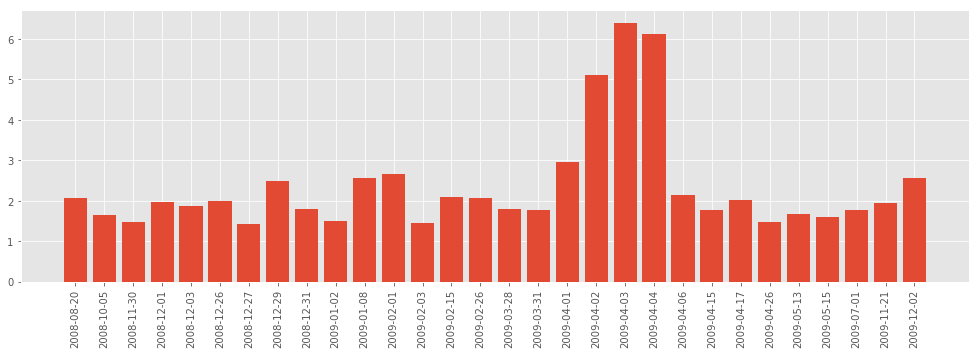

In [77]:
profitRatioZScoreTop30 = profitRatioZScore[0:30]
orderedXTop30 = orderedX[0:30]

orderedXTop30,profitRatioZScoreTop30= zip(*sorted(zip(orderedXTop30,profitRatioZScoreTop30)))

plt.figure(figsize=(17,5))
plt.bar(range(len(profitRatioZScoreTop30)), profitRatioZScoreTop30)
plt.xticks(np.arange(len(profitRatioZScoreTop30)), orderedXTop30,rotation='vertical')
plt.show()

Secondly, the lowest 30 z-score values for the profit ratio within the dates contained in the dataset are shown. June, July, August and October are the months in which more low z-score values can be found.

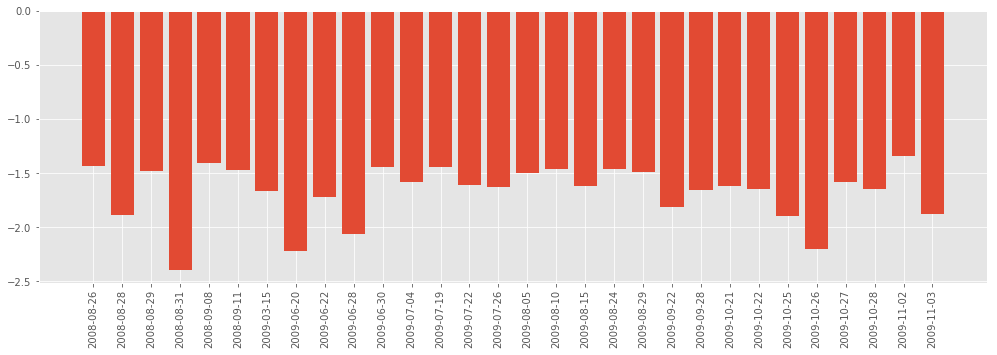

In [78]:
profitRatioZScore,orderedX= zip(*sorted(zip(profitRatioZScore,orderedX),reverse=False))
profitRatioZScore

profitRatioZScoreWorse30 = profitRatioZScore[0:30]
orderedXWorse30 = orderedX[0:30]

orderedXWorse30,profitRatioZScoreWorse30= zip(*sorted(zip(orderedXWorse30,profitRatioZScoreWorse30)))

plt.figure(figsize=(17,5))
plt.bar(range(len(profitRatioZScoreWorse30)), profitRatioZScoreWorse30)
plt.xticks(np.arange(len(profitRatioZScoreWorse30)), orderedXWorse30,rotation='vertical')
plt.show()

Now, the profit ratio for special dates is analyzed. These include the federal holidays in the USA, Black Friday, the week before Valentine's Day, and Christmas' season (December).

In [79]:
federalPublicHolidaysUSA2008 = ['2008-01-01','2008-01-21','2008-02-18','2008-05-26','2008-07-04','2008-09-01','2008-10-13','2008-11-11','2008-11-27','2008-11-28','2008-12-25']
federalPublicHolidaysUSA2009 = ['2009-01-01','2009-01-19','2009-02-16','2009-05-25','2009-07-03','2009-09-07','2009-10-12','2009-11-11','2009-11-26','2009-11-27','2009-12-25']
blackFriday2008 = ['2008-11-28']
blackFriday2009 = ['2009-11-27']
valentinesDay2008Season = ['2008-02-07','2008-02-08','2008-02-09','2008-02-10','2008-02-11','2008-02-12','2008-02-13','2008-02-14']
valentinesDay2009Season = ['2009-02-07','2009-02-08','2009-02-09','2009-02-10','2009-02-11','2009-02-12','2009-02-13','2009-02-14']

christmas2008Season = []
christmas2009Season = []
for i in range (1,32):
    dayString = '%02d' % i
    christmas2008Season.append('2008-12-'+dayString)
    christmas2009Season.append('2009-12-'+dayString)

In [80]:
orderedX,profitRatioZScore= zip(*sorted(zip(orderedX,profitRatioZScore)))
holidayTypeToProfitRatioZScore = {}

for i in range(0,len(orderedX)):
    dateToAnalyzeString = str(orderedX[i])
    isFederalPublicHolidayUSA2008 =  dateToAnalyzeString in federalPublicHolidaysUSA2008
    isFederalPublicHolidayUSA2009 = dateToAnalyzeString in federalPublicHolidaysUSA2009
    isFederalPublicHolidayUSA = isFederalPublicHolidayUSA2008 or isFederalPublicHolidayUSA2009
    
    isBlackFriday2008 = dateToAnalyzeString in blackFriday2008
    isBlackFriday2009 = dateToAnalyzeString in blackFriday2009
    isBlackFriday = isBlackFriday2008 or isBlackFriday2009
    
    isValentinesDay2008Season = dateToAnalyzeString in valentinesDay2008Season
    isValentinesDay2009Season = dateToAnalyzeString in valentinesDay2009Season
    isValentinesDaySeason = isValentinesDay2008Season or isValentinesDay2009Season
    
    isChristmas2008Season = dateToAnalyzeString in christmas2008Season
    isChristmas2009Season = dateToAnalyzeString in christmas2009Season
    isChristmasSeason = isChristmas2008Season or isChristmas2009Season
    
    holidayType = []
    yearString = dateToAnalyzeString[0:4]
    
    if isFederalPublicHolidayUSA:
        holidayType.append("FederalPublicHolidayUSA")
    if isBlackFriday:
        holidayType.append("BlackFriday")
    if isValentinesDaySeason:
        holidayType.append("ValentinesDaySeason")
    if isChristmasSeason:
        holidayType.append("ChristmasSeason")
    
    if holidayType:
        for holiday in holidayType:       
            holidayTypePlusYearString = holiday + yearString
        
            if holidayTypePlusYearString in holidayTypeToProfitRatioZScore:
                holidayTypeProfitRatioZScore = holidayTypeToProfitRatioZScore[holidayTypePlusYearString]
                holidayTypeProfitRatioZScore.append((dateToAnalyzeString,profitRatioZScore[i]))
            else:
                holidayTypeToProfitRatioZScore[holidayTypePlusYearString] = [(dateToAnalyzeString,profitRatioZScore[i])]
            
#holidayTypeToProfitRatioZScore

Black Friday has a positive z-score both in 2008 and 2009. Christmas' season (December) has days with both positive and negative z-score values (also, there is no complete data for December 2009). With the available data for December 2008, it can be concluded that the z-score is generally positive during the second half of December, with the highest values towards the end of the month. Public holidays have both positive and negative z-score values. The last days before 2009 Valentine's Day have positive z-score values.

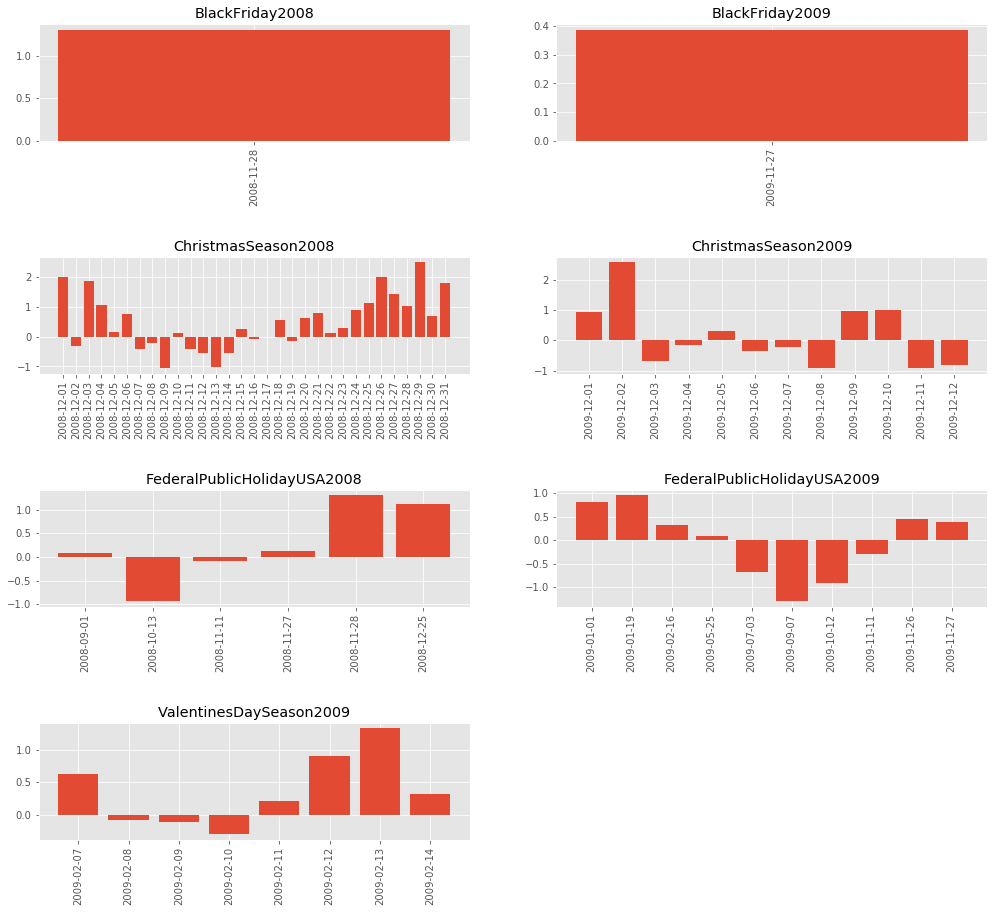

In [81]:
subplotIndex = 1

plt.figure(figsize=(17,15))  

for key in sorted(holidayTypeToProfitRatioZScore.keys()):
    value = holidayTypeToProfitRatioZScore[key]
    plt.subplot(4,2,subplotIndex)
    plt.title(key)
    
    X = [tupleElement[0] for tupleElement in value]
    Y = [tupleElement[1] for tupleElement in value]
    plt.bar(range(len(Y)), Y)
    plt.xticks(np.arange(len(Y)), X,rotation='vertical')
    subplotIndex = subplotIndex +1
    
plt.subplots_adjust(hspace = 1)
plt.show()

Now, it is analyzed whether the day of the week (Monday-Sunday) has any efect on Swoopo's profit. The following figure represents the sum of the retail price of the auctioned items as well as the revenue obtained by Swoopo (calculated as the profit obtained over the retail price of the items plus their retail price), where 0 corresponds to Monday and 6 corresponds to Sunday.

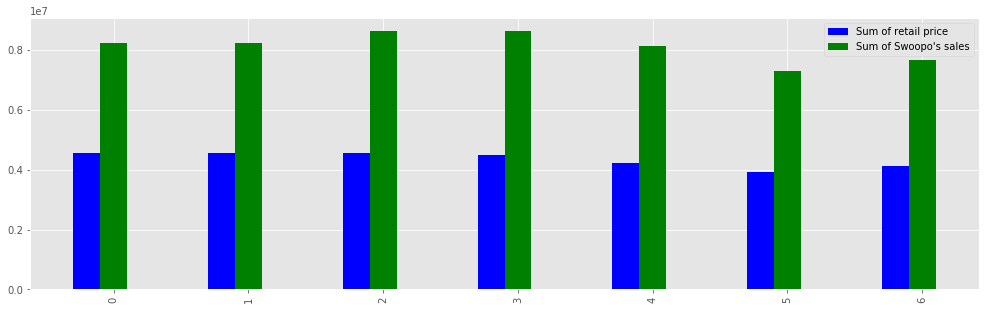

In [85]:
f = lambda x: str(x.dayofweek)

sumRetailGroup = outcomesDf.groupby(outcomesDf['endtime_str'].apply(f))['retail'].sum()
swoopoProfitGroup = outcomesDf.groupby(outcomesDf['endtime_str'].apply(f))['swoopo_profit'].sum()

X=sumRetailGroup.index
Y=sumRetailGroup.values
Y2 = swoopoProfitGroup.values
bar_width = 0.20

plt.figure(figsize=(17,5))
p1=plt.bar(np.arange(len(Y)),Y, bar_width,color='b')
p2=plt.bar(np.arange(len(Y2))+bar_width,Y2+Y,bar_width, color='g')
plt.xticks(np.arange(len(X)) + bar_width, X,rotation='vertical')
plt.legend((p1,p2),('Sum of retail price', 'Sum of Swoopo\'s sales'))
plt.show()

The highest profit ratio is obtained on Friday, while the lowest positive ratio is obtained on Tuesday. Nevertheless, the values are pretty similar throughout all days of the week.

In [86]:
profitRatio = (Y2+Y)/Y
profitRatio,X= zip(*sorted(zip(profitRatio,X)))
for i in range(0,7):
    print (str(X[i])+ " : "+str(profitRatio[i]))

1 : 1.79960214622
0 : 1.81110240645
6 : 1.85394790398
5 : 1.85787517573
2 : 1.8979654475
3 : 1.91604387013
4 : 1.92160198512


In [ ]:
outcomesDfItemDesc =outcomesDf[['item','desc']]
outcomesDfItemDesc.head()
outcomesDfItemDesc.shape
itemColumnValueCounts = outcomesDf['item'].value_counts()
itemColumnValueCounts.head()
outcomesDfItemDesc.shape
outcomesDfItemDesc = outcomesDfItemDesc.merge(itemColumnValueCounts.to_frame(),how='left',left_on='item',right_index=True)
outcomesDfItemDesc = outcomesDfItemDesc.rename(columns={'item_x': 'item', 'item_y': 'item_count'})
outcomesDfItemDesc.shape
outcomesDfItemDesc
descColumnValueCounts = outcomesDf['desc'].value_counts()
descColumnValueCounts.head()
outcomesDfItemDesc = outcomesDfItemDesc.merge(descColumnValueCounts.to_frame(),how='left',left_on='desc',right_index=True)
outcomesDfItemDesc = outcomesDfItemDesc.rename(columns={'desc_x': 'desc', 'desc_y': 'desc_count'})
outcomesDfItemDesc.shape
outcomesDfItemDesc.head()
outcomesDfItemDesc[outcomesDfItemDesc['item_count']!=outcomesDfItemDesc['desc_count']]['item'].unique()

In [ ]:
outcomesDfItemDesc[outcomesDfItemDesc['item'].values=="casio-exilim-ex-z200-10-1-mp-digital-cam"]['desc'].unique()

In [ ]:
for itemdesc in outcomesDf['desc'].unique():
    print(itemdesc)

In [ ]:
productCategoriesDf = pd.read_excel('./product_categories.xlsx')
productCategoriesDf.head()

In [ ]:
outcomesDfWithCategory = outcomesDf.merge(productCategoriesDf[['desc','category']],how='left')
outcomesDfWithCategory.head()

In [ ]:
outcomesDfWithCategory[outcomesDfWithCategory.isnull().any(1)]

In [ ]:
productCategoriesDf[productCategoriesDf['item'] == 'perig-um-diamond-retrograde']

In [ ]:
productCategoriesDf.loc[productCategoriesDf['item'].values=="garmin-n-vi-250-3-5-inch-portable-gps-na", 'desc'] = "Garmin nüvi 250 3.5-Inch Portable GPS Navigator"
productCategoriesDf.loc[productCategoriesDf['item'].values=="krug-ba-men-regatta-diamond-mens-watch", 'desc'] = "Krug Baümen Regatta Diamond Mens Watch"
productCategoriesDf.loc[productCategoriesDf['item'].values=="perig-um-llandudno-ladies-watch", 'desc'] = "Perigáum Llandudno Ladies Watch"
productCategoriesDf.loc[productCategoriesDf['item'].values=="pok-mon-ranger-shadows-of-almia-nintendo", 'desc'] = "Pokémon Ranger: Shadows of Almia (Nintendo DS)"
productCategoriesDf.loc[productCategoriesDf['item'].values=="perig-um-florentia-ladies-watch", 'desc'] = "Perigáum Florentia Ladies Watch"
productCategoriesDf.loc[productCategoriesDf['item'].values=="perig-um-leticia-ladies-watch", 'desc'] = "Perigáum Leticia Ladies Watch"
productCategoriesDf.loc[productCategoriesDf['item'].values=="perig-um-saint-lucia-ladies-watch", 'desc'] = "Perigáum Saint Lucia Ladies Watch"
productCategoriesDf.loc[productCategoriesDf['item'].values=="samsung-ln40a630-40-inch-1080p-120hz-lcd", 'desc'] = "Samsung LN40A630 40-Inch 1080p 120Hz LCD HDTV"
productCategoriesDf.loc[productCategoriesDf['item'].values=="perig-um-moonwalker-mens-luxury-watch", 'desc'] = "Perigáum Moonwalker Mens Luxury Watch"
productCategoriesDf.loc[productCategoriesDf['item'].values=="perig-um-fiona-ladies-watch", 'desc'] = "Perigáum Fiona Ladies Watch"
productCategoriesDf.loc[productCategoriesDf['item'].values=="perig-um-diamond-retrograde", 'desc'] = "Perigáum Diamond Retrograde"


In [ ]:
outcomesDf['winner'].value_counts()

In [ ]:
outcomesDf['desc'].value_counts()

In [ ]:
outcomesDf.head()

In [ ]:
outcomesDf['bidincrement'] = outcomesDf['bidincrement']/100
outcomesDf['bidfee'] = outcomesDf['bidfee']/100

In [ ]:
outcomesDf['finalprice_withbids'] = outcomesDf['finalprice'] + outcomesDf['placedbids']*outcomesDf['bidfee']/100

In [ ]:
X = outcomesDf[["retail","bidincrement","bidfee","flg_click_only","flg_beginnerauction","flg_fixedprice","flg_endprice"]].values
y = outcomesDf["finalprice"]

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rmodel=RandomForestRegressor()
rmodel.fit(X,y)
outcomesDf['P_finalprice'] = rmodel.predict(outcomesDf[["retail","bidincrement","bidfee","flg_click_only","flg_beginnerauction","flg_fixedprice","flg_endprice"]])

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(outcomesDf["finalprice"],outcomesDf["P_finalprice"])

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
clf = KNeighborsRegressor(n_neighbors=14)
clf.fit(X, y)
mean_squared_error(outcomesDf["finalprice"],clf.predict(X))

In [ ]:
from sklearn.tree import DecisionTreeRegressor
clf = DecisionTreeRegressor(max_depth=5)
clf.fit(X, y)
mean_squared_error(outcomesDf["finalprice"],clf.predict(X))

In [ ]:
from sklearn.linear_model import LinearRegression
clf = LinearRegression()
clf.fit(X, y)
mean_squared_error(outcomesDf["finalprice"],clf.predict(X))

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn import decomposition
from sklearn.ensemble import RandomForestRegressor

In [ ]:
red = decomposition.PCA()
clf = RandomForestRegressor()
pipe = Pipeline(steps=[('pca', red), ('Random Forest',clf)])
pipe.fit(X_train,y_train)
mean_squared_error(y_test,pipe.predict(X_test))

In [ ]:
rmodel=RandomForestRegressor()
rmodel.fit(X_train,y_train)
mean_squared_error(y_test,rmodel.predict(X_test))

In [ ]:
#pip install tpot
from tpot import TPOTRegressor
clf = TPOTRegressor(generations=5, population_size=20, cv=5,
                                    random_state=42, verbosity=2)
clf.fit(X_train, y_train)

In [ ]:
mean_squared_error(y_test,clf.predict(X_test))